In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,Dense,MaxPooling2D,UpSampling2D
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
from PIL import Image
import cv2 as cv
import numpy as np
from pathlib import Path
import os
import random
import tqdm

2024-01-24 03:22:08.635235: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-24 03:22:08.927930: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-24 03:22:08.928025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-24 03:22:08.965320: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-24 03:22:09.066932: I tensorflow/core/platform/cpu_feature_guar

In [2]:
tf.config.set_visible_devices([], 'GPU')

2024-01-24 03:23:09.173324: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-24 03:23:09.336532: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-24 03:23:09.336957: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
cwd = Path.cwd()

In [4]:
list_images = list(cwd.glob("*/*/*/*.jpg"))
len(list_images)

465

In [5]:
for   dirpath, dirnames, filenames in os.walk(Path.joinpath(cwd,'Chessman-image-dataset/Chess')):
    print(f"Inside {Path(dirpath).stem} there are {len(dirnames)} directories and {len(filenames)} files.")

Inside Chess there are 6 directories and 0 files.
Inside Rook there are 0 directories and 102 files.
Inside King there are 0 directories and 76 files.
Inside Queen there are 0 directories and 78 files.
Inside Bishop there are 0 directories and 87 files.
Inside Knight there are 0 directories and 106 files.
Inside Pawn there are 0 directories and 107 files.


In [6]:
Train_images = []
for image_address in list_images:
    Image = cv.imread(str(image_address))
    Image = cv.cvtColor(Image,cv.COLOR_BGR2RGB)
    Image = cv.resize(Image,dsize=(256,256))
    Train_images.append(np.array(Image))


In [7]:
random.shuffle(Train_images)

In [8]:
Train_images[4].shape

(256, 256, 3)

In [9]:
Train_images = np.array(Train_images)


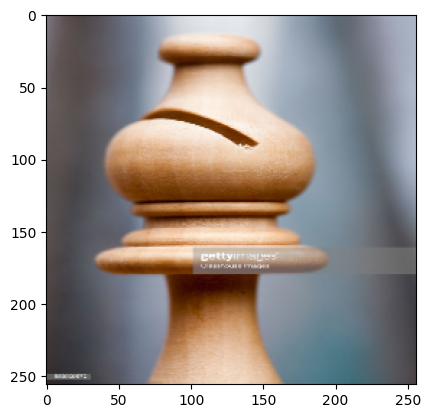

In [10]:
x = random.randint(0,len(Train_images))
plt.imshow(Train_images[x])

In [11]:
# Normalizing the images
Train_images = Train_images/255

In [12]:
batch_size =32
num_samples = len(Train_images)
num_batches = num_samples // batch_size

batches = []
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    batch = Train_images[start_idx:end_idx]
    batches.append(batch)
batches = np.array(batches)

In [13]:
batches.shape
batches[0]

array([[[[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        ...,

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]

In [18]:
# Define the autoencoder model
encode_decode = tf.keras.Sequential([
    Conv2D(32,(3,3),padding = 'same', activation='relu',input_shape=(256,256,3)),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(32,(3,3),padding = 'same', activation='relu'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(16,(3,3),padding = 'same', activation='relu'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(16,(3,3),padding = 'same', activation='relu'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(8,(3,3),padding = 'same', activation='relu'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(4,(3,3),padding = 'same', activation='relu'),
    MaxPooling2D((2, 2), padding='same'),

    UpSampling2D((2,2)),
    Conv2D(4,(3,3),padding = 'same', activation='relu'),
    UpSampling2D((2,2)),
    Conv2D(8,(3,3),padding = 'same', activation='relu'),
    UpSampling2D((2,2)),
    Conv2D(16,(3,3),padding = 'same', activation='relu'),
    UpSampling2D((2,2)),
    Conv2D(16,(3,3),padding = 'same', activation='relu'),
    UpSampling2D((2,2)),
    Conv2D(8,(3,3),padding = 'same', activation='relu'),
    UpSampling2D((2,2)),
    Conv2D(3,(3,3),padding = 'same', activation='relu'),
])


In [19]:
encode_decode.compile(optimizer = 'adam',loss= 'mean_squared_error',metrics = ['accuracy'])
encode_decode.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 32, 32, 16)       

In [52]:

encode_decode.fit(Train_images,Train_images,epochs=200,batch_size=32)

In [51]:
encode_decode.save_weights("Saved weights.h5")

In [44]:
x = random.randint(1,len(Train_images))
image = Train_images[x]
image.shape

(256, 256, 3)

In [45]:
image = image.reshape(1,256,256,3)
image_predicted = encode_decode.predict(image)

1/1 [==============================] - 0s 39ms/step


In [46]:
image_predicted = image_predicted.squeeze()

In [47]:
image_predicted

array([[[0.59303147, 0.8095527 , 0.8202483 ],
        [0.78024524, 1.0687839 , 0.98193437],
        [0.7162521 , 0.99178827, 0.98271847],
        ...,
        [0.7735865 , 0.7762001 , 0.7955705 ],
        [0.8616206 , 0.7449159 , 0.781636  ],
        [0.63462704, 0.34679988, 0.3995008 ]],

       [[0.98556745, 0.9662541 , 0.9308355 ],
        [1.0655067 , 1.1452122 , 1.01921   ],
        [0.99489   , 1.0967963 , 0.9897195 ],
        ...,
        [0.81540036, 0.99246347, 0.8895278 ],
        [0.9854662 , 0.9467128 , 0.9888002 ],
        [0.81221825, 0.8112643 , 0.752261  ]],

       [[0.9443209 , 0.9788614 , 1.0552193 ],
        [1.0129533 , 1.0261141 , 1.0895234 ],
        [0.9426283 , 1.0341513 , 1.0706325 ],
        ...,
        [0.83317417, 1.0317986 , 0.91982204],
        [1.0099491 , 1.000716  , 1.003725  ],
        [0.90540665, 0.88229805, 0.8013018 ]],

       ...,

       [[0.35603637, 0.30997568, 0.35672897],
        [0.3780917 , 0.2939987 , 0.2836822 ],
        [0.28041112, 0

((256, 256, 3), array([1., 1., 1.]))

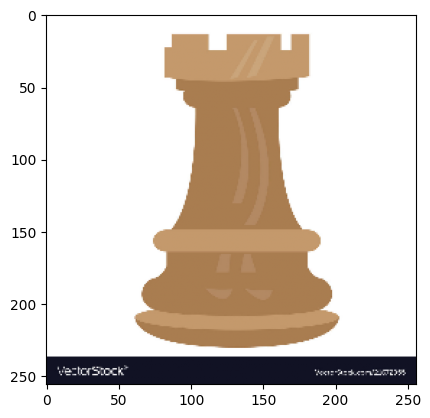

In [48]:
plt.imshow(Train_images[x])
Train_images[0].shape,Train_images[0][0][0]

In [49]:
print(image_predicted.shape)  # Add this line to check the shape

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


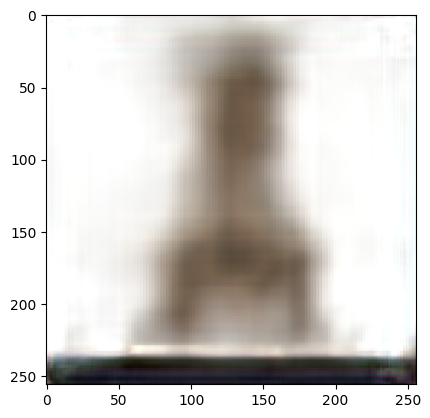

In [50]:
plt.imshow(image_predicted)